Premier rendu du projet du cour `advanced topics in deep learning`

Equipe :
*   LARROYE Rémy
*   MESSAN Adjo-Sika Aurore  
*   MONIN Donélia  
*   ROSSEL Jacques



In [ ]:
from os import path

if not path.exists("dataset_44_spambase.csv"):
  !wget https://www.openml.org/data/get_csv/44/dataset_44_spambase.csv

--2021-02-24 19:06:31--  https://www.openml.org/data/get_csv/44/dataset_44_spambase.csv
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘dataset_44_spambase.csv’

dataset_44_spambase     [  <=>               ] 682.99K  1.58MB/s    in 0.4s    

2021-02-24 19:06:31 (1.58 MB/s) - ‘dataset_44_spambase.csv’ saved [699384]



In [ ]:
import torch
import math
import pandas as pd
from sklearn.model_selection import train_test_split


dataframe = pd.read_csv('dataset_44_spambase.csv')#load data from local

dataframe=((dataframe-dataframe.min())/(dataframe.max()-dataframe.min()))# normalization of the data

x_df = dataframe.iloc[:,:57]#split data beetwenn input 
y_df = dataframe.iloc[:,57:]#and labels
print("Pourcentage de spam dans le dataset : ", y_df["class"].sum()/len(y_df)*100)

#separation du dataset en Train et Test 80 / 20

x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_df, y_df, test_size=0.20)

print("Pourcentage de spam dans le test : ", y_test_df["class"].sum()/len(y_test_df)*100)

#separation du dataset en Train et Validation 80 / 20
x_train_df, x_valid_df, y_train_df, y_valid_df = train_test_split(x_train_df, y_train_df, test_size=0.20)

print("Pourcentage de spam dans le train : ", y_train_df["class"].sum()/len(y_train_df)*100)

print("Pourcentage de spam dans le validation : ", y_valid_df["class"].sum()/len(y_valid_df)*100)

Pourcentage de spam dans le dataset :  39.404477287546186
Pourcentage de spam dans le test :  40.390879478827365
Pourcentage de spam dans le train :  39.639945652173914
Pourcentage de spam dans le validation :  37.22826086956522


In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):

        # Load data and get label
        X = self.list_IDs[index]
        y = self.labels[index]

        return X, int(y[0])

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def train(net, N_EPOCHS, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Assuming that we are on a CUDA machine, this should print a CUDA device:
  print(device)
  
  net = net.float()
  net = net.to(device)
  epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

  pbar = tqdm(total=(N_EPOCHS* math.ceil(len(train_set)/train_dl.batch_size)) + N_EPOCHS* math.ceil(len(valid_set)/valid_dl.batch_size))

  for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
      running_loss = 0.0
      running_accuracy = 0.0
      for i, data in enumerate(train_dl, 0):
          pbar.update(1)
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs.float())
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          running_accuracy += (outputs.max(1)[1] == labels).sum().item()

      epoch_loss.append(running_loss/len(train_set))
      epoch_acc.append(running_accuracy/len(train_set))

      net.eval()

      running_val_loss = 0.0
      running_val_accuracy = 0.0
      for i, data in enumerate(valid_dl, 0):
          pbar.update(1)
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs.float())
          loss = criterion(outputs, labels)

          running_val_loss += loss.item()
          running_val_accuracy += (outputs.max(1)[1] == labels).sum().item()

      epoch_val_loss.append(running_val_loss/len(valid_set))
      epoch_val_acc.append(running_val_accuracy/len(valid_set))
  pbar.close() 
  plt.figure(figsize=(15,10))

  plt.subplot(2, 2, 1)
  plt.title("Accurary")
  plt.plot(epoch_acc, label="Training")
  plt.plot(epoch_val_acc, label="Validation")
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.title("Loss")
  plt.plot(epoch_loss, label="Training")
  plt.plot(epoch_val_loss, label="Validation")
  plt.legend()

  plt.show()

def test (net, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Assuming that we are on a CUDA machine, this should print a CUDA device:
  net = net.to(device)
  net.eval()
  running_test_accuracy = 0.0
  for i, data in enumerate(test_dl, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs.float())
      loss = criterion(outputs, labels)
      running_test_accuracy += (outputs.max(1)[1] == labels).sum().item()
  print("Accuracy on test dataset : ", running_test_accuracy/len(test_set))

In [ ]:
train_set = Dataset(torch.tensor(x_train_df.values), y_train_df.values)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

valid_set = Dataset(torch.tensor(x_valid_df.values), y_valid_df.values)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=True)

test_set = Dataset(torch.tensor(x_test_df.values), y_test_df.values)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
class reseauDense(torch.nn.Module):

  def __init__(self):
    super(reseauDense, self).__init__()
    
    self.linear1 = torch.nn.Linear(57, 1000)
    self.linear2 = torch.nn.Linear(1000, 250)
    self.linear3 = torch.nn.Linear(250, 50)

    self.droput = torch.nn.Dropout(0.2)

    self.relu = torch.nn.ReLU()

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x): 
    x = self.linear1(x)

    x = self.droput(x)
    x = self.relu(x)

    x = self.linear2(x)
    x = self.droput(x)
    x = self.relu(x)
    
    
    x = self.linear3(x)
    y = self.softmax(x)

    return y

cuda:0


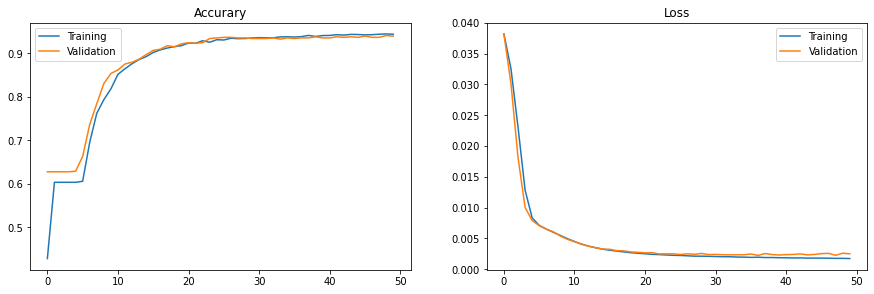

Accuracy on test dataset :  0.9283387622149837


In [ ]:
net = reseauDense()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train(net, 50, criterion, optimizer)
test(net, criterion, optimizer)

cuda:0


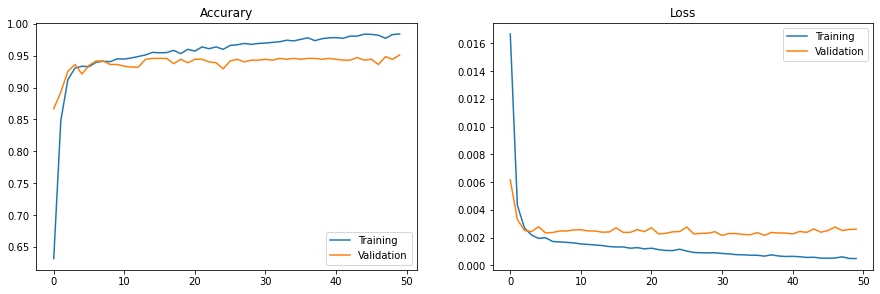

Accuracy on test dataset :  0.9478827361563518


In [ ]:
net = reseauDense()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, 50, criterion, optimizer)
test(net, criterion, optimizer)

cuda:0


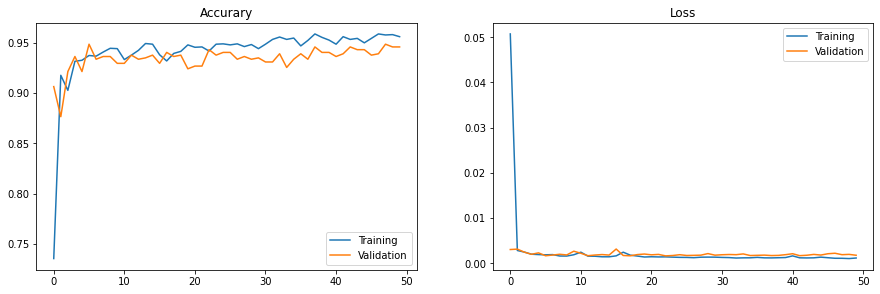

Accuracy on test dataset :  0.9326818675352877


In [ ]:
net = reseauDense()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.15)
train(net, 50, criterion, optimizer)
test(net, criterion, optimizer)

cuda:0


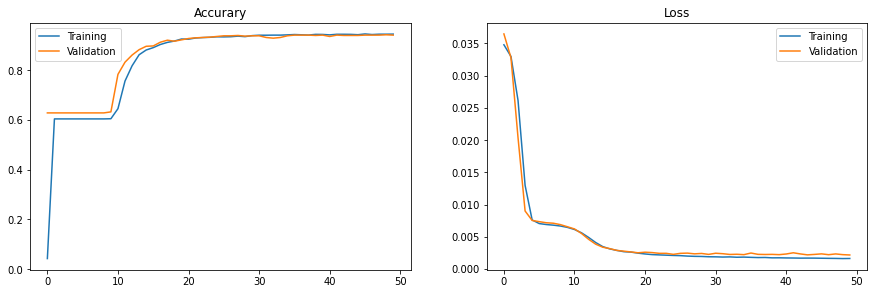

Accuracy on test dataset :  0.9305103148751357


In [ ]:
class MultiLayer(torch.nn.Module):

  def __init__(self):
    super(MultiLayer, self).__init__()
    
    self.linear1 = torch.nn.Linear(57,1024)
    self.linear2 = torch.nn.Linear(1024,256)
    self.linear3 = torch.nn.Linear(256,128)
    self.linear4 = torch.nn.Linear(128,64)
    self.linear5 = torch.nn.Linear(64,32)


    self.droput = torch.nn.Dropout(0.2)

    self.relu = torch.nn.ReLU()

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x): 
    x = self.linear1(x)

    x = self.droput(x)
    x = self.relu(x)

    x = self.linear2(x)
    x = self.droput(x)
    x = self.relu(x)
    
    x = self.linear3(x)
    x = self.droput(x)
    x = self.relu(x)

    x = self.linear4(x)
    x = self.droput(x)
    x = self.relu(x)

    x = self.linear5(x)
    y = self.softmax(x)

    return y


multiLayer = MultiLayer()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(multiLayer.parameters(), lr=0.0001)
train(multiLayer, 50, criterion, optimizer)
test(multiLayer, criterion, optimizer)

cuda:0


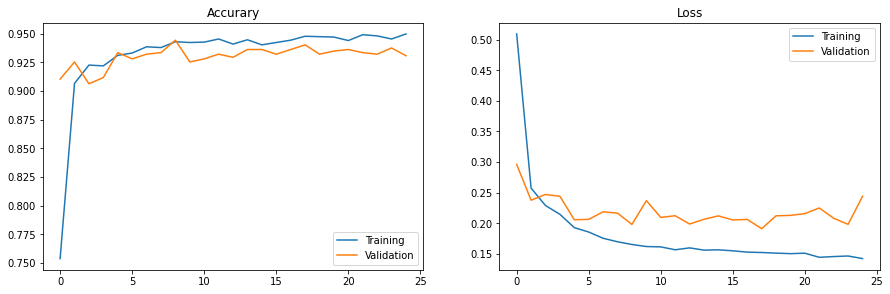

Accuracy on test dataset :  0.9554831704668838


In [ ]:
import torch.nn.functional as F

train_set = Dataset(torch.tensor(x_train_df.values).unsqueeze_(-1), y_train_df.values)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

valid_set = Dataset(torch.tensor(x_valid_df.values).unsqueeze_(-1), y_valid_df.values)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=True)

test_set = Dataset(torch.tensor(x_test_df.values).unsqueeze_(-1), y_test_df.values)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
class reseauCNN(torch.nn.Module):

  def __init__(self):
    super(reseauCNN, self).__init__()
    self.conv1 = torch.nn.Conv1d(in_channels = 1, out_channels = 57, kernel_size=1, padding=2)
    self.conv2 = torch.nn.Conv1d(in_channels = 57, out_channels = 100, kernel_size=5, padding=2)
    self.conv3 = torch.nn.Conv1d(in_channels = 100, out_channels = 200, kernel_size=20, padding=11)

    self.pool = torch.nn.MaxPool1d(2)

    self.relu = torch.nn.ReLU()

    self.out_layer = torch.nn.Linear(22800, 50)

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = x.transpose(0, 1).contiguous()
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 22800)
    x = self.out_layer(x)
    y = self.softmax(x)

    return y
  
net = reseauCNN()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, 25, criterion, optimizer)
test(net, criterion, optimizer)

In [ ]:
class reseauDense_Lerelu(torch.nn.Module):

  def __init__(self):
    super(reseauDense_Lerelu, self).__init__()
    
    self.linear1 = torch.nn.Linear(57, 1000)
    self.linear2 = torch.nn.Linear(1000, 250)
    self.linear3 = torch.nn.Linear(250, 50)

    self.droput = torch.nn.Dropout(0.2)

    self.LeakyReLU = torch.nn.LeakyReLU()

    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x): 
    x = self.linear1(x)

    x = self.droput(x)
    x = self.LeakyReLU(x)

    x = self.linear2(x)
    x = self.droput(x)
    x = self.LeakyReLU(x)
    
    
    x = self.linear3(x)
    y = self.softmax(x)
    
    return y

In [ ]:
net = reseauDense_Lerelu()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train(net, 50, criterion, optimizer)
test(net, criterion, optimizer)

shap.initjs() 
predictor = Predictor(net)
explainer = shap.KernelExplainer(predictor.predict, x_train_df.iloc[:100,:])
shap_values50 = explainer.shap_values(x_test_df.iloc[:nbValue,:], nsamples=500)

shap.summary_plot(shap_values50, x_test_df.iloc[:nbValue,:])

NameError: ignored